In [ ]:
# !git clone https://github.com/luchonaveiro/image-search-engine.git

Cloning into 'image-search-engine'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 5), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [ ]:
! cd /content/drive/MyDrive/image-search-engine

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D,Conv2DTranspose, LeakyReLU,ReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
import os

In [ ]:
# Load images
img_height = 256
img_width = 256
channels = 3
batch_size = 16

train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/similar/class',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/similar/class',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


In [ ]:

model = keras.Sequential()
# TODO : 지시사항을 잘 보고 VGG16 Net을 완성해보세요.

# 첫 번째 Conv Block
# 입력 Shape는 ImageNet 데이터 세트의 크기와 같은 RGB 영상 (224 x 224 x 3)입니다.
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same" ,activation="relu", input_shape = (256, 256, 3)))
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", ))
model.add(keras.layers.MaxPooling2D(2))

# 두 번째 Conv Block
model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.MaxPooling2D(2)),

# 세 번째 Conv Block
model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.MaxPooling2D(2)),

# 네 번째 Conv Block
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.MaxPooling2D(2)),

# 다섯 번째 Conv Block
# TODO: 다섯 번째 Conv Block은 네 번째 Block과 동일합니다. 앞의 코드를 참고하여 다섯 번째 Block를 추가하세요
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = "relu", padding = "same" ))
model.add(keras.layers.MaxPooling2D(2)),

# Fully Connected Layer
model.add(keras.layers.Flatten()),
model.add(keras.layers.Dense(4096, activation = "relu")),
model.add(keras.layers.Dense(4096, activation = "relu")),
model.add(keras.layers.Dense(1000, activation = "sigmoid")) # 마지막 레이어의 노드수를 2로 변경하세요

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Fit the model
history = model.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=50
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_vgg_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False),
                       EarlyStopping( monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)])

# Save model
#autoencoder.save('models/image_autoencoder_2.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50


ValueError: ignored

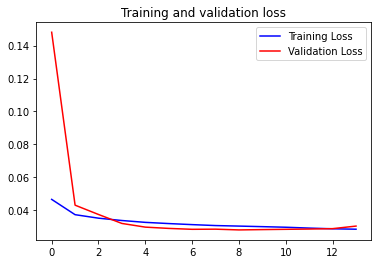

In [ ]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
autoencoder = load_model('models/image_autoencoder_2.h5', compile=False)